# Assignment 02

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Machine Learning
- Course ID: BDA500NAA.05380.2237
- Professor: Dr. Amir Moslemi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import cv2

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve


In [2]:
# load dataset
from mat4py import loadmat 
data = loadmat('CatDog.mat')

In [3]:
# get the feature matrix
X = np.array(data['X']).T
print(f"Observations: {X.shape[0]}, Features: {X.shape[1]}")

# get the target vector
y = np.array(data['G'])
print(f'Dimension: {y.shape}')

Observations: 242, Features: 4096
Dimension: (242,)


(242, 64, 64, 1)


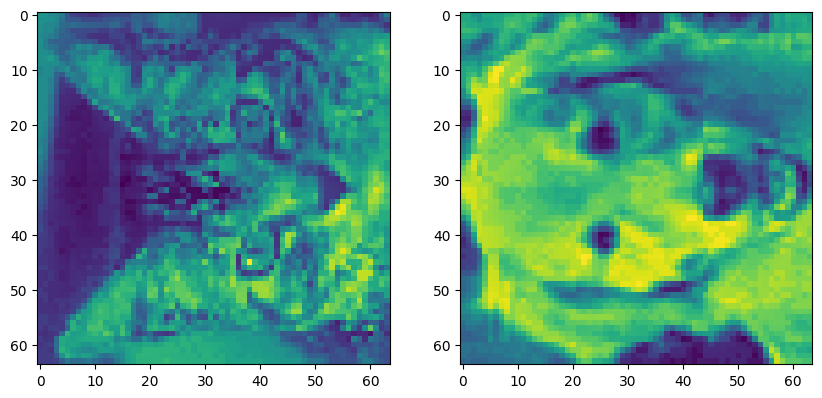

In [4]:
# normalizing data
X_min, X_max = X.min(), X.max()
X_norm = (X - X_min) / (X_max - X_min)
# reshape data
X_norm_ = X_norm.reshape(242, 64, 64, 1)
print(X_norm_.shape)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(X_norm_[0])
ax[1].imshow(X_norm_[-1])

In [5]:
# resizing the image pixel sizes

# create empty matrix pf the desired image pixel sizes
resized_X = np.empty((242, 224, 224, 1))

# start resizing
for i in range(X_norm_.shape[0]):
    # Resize each image and store it in the new array
    resized_image = cv2.resize(X_norm_[i, :, :, 0], (224, 224))
    resized_X[i] = np.expand_dims(resized_image, axis=-1)

# show dimensions
resized_X.shape

(242, 224, 224, 1)

(242, 64, 64, 1)


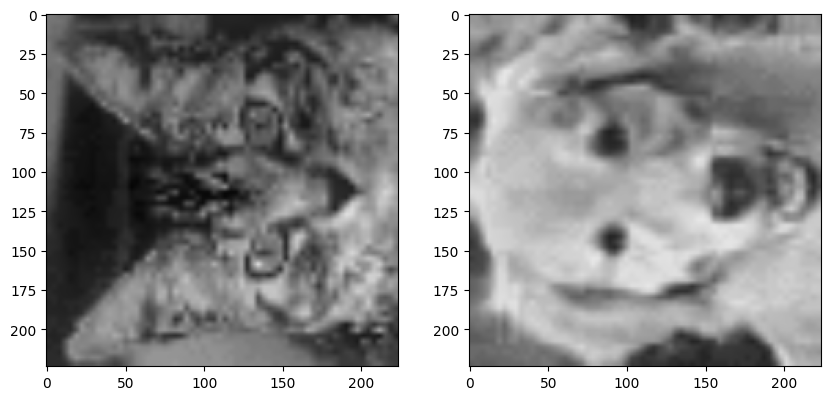

In [6]:
# converting from gray scale to the RGB scale
resized_X = np.repeat(resized_X, 3, axis=-1)
print(X_norm_.shape)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(resized_X[0])
ax[1].imshow(resized_X[-1])

(242, 224, 224, 3)


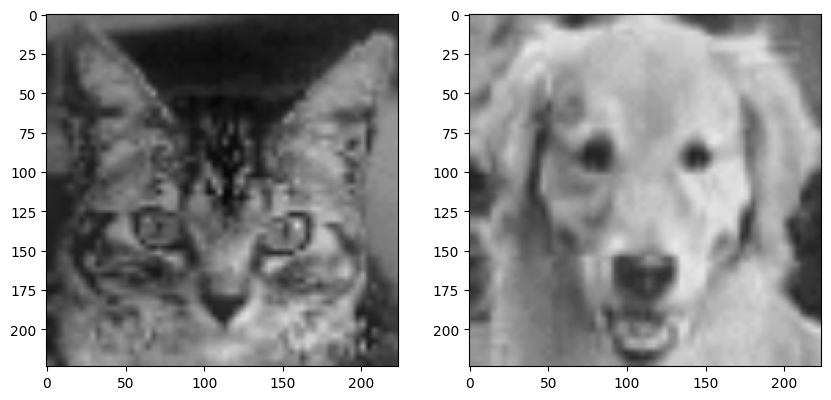

In [7]:
# transpose the data
trans_X = np.transpose(resized_X, (0, 2, 1, 3))
print(trans_X.shape)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(trans_X[0])
ax[1].imshow(trans_X[-1])

In [12]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(trans_X, y, test_size=0.3, random_state=0, stratify=y)

print('Training: ')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print('Test: ')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Training: 
X: (169, 224, 224, 3), y: (169,)
Test: 
X: (73, 224, 224, 3), y: (73,)


In [13]:
# loading VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# show summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# create new model
model = Sequential()
# add VGG16 model
model.add(base_model)

# new layers for binary classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17934401 (68.41 MB)
Trainable params: 3219713 (12.28 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
# training the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
6/6 [==============================] - 27s 4s/step - loss: 1.1325 - accuracy: 0.4675 - val_loss: 0.5488 - val_accuracy: 0.6438
Epoch 2/15
6/6 [==============================] - 24s 4s/step - loss: 0.4398 - accuracy: 0.7870 - val_loss: 0.3924 - val_accuracy: 0.7808
Epoch 3/15
6/6 [==============================] - 23s 4s/step - loss: 0.2141 - accuracy: 0.9290 - val_loss: 0.3015 - val_accuracy: 0.8767
Epoch 4/15
6/6 [==============================] - 23s 4s/step - loss: 0.1132 - accuracy: 0.9763 - val_loss: 0.1576 - val_accuracy: 0.9726
Epoch 5/15
6/6 [==============================] - 24s 4s/step - loss: 0.0977 - accuracy: 0.9822 - val_loss: 0.1319 - val_accuracy: 0.9452
Epoch 6/15
6/6 [==============================] - 24s 4s/step - loss: 0.0726 - accuracy: 0.9941 - val_loss: 0.1040 - val_accuracy: 0.9726
Epoch 7/15
6/6 [==============================] - 24s 4s/step - loss: 0.0365 - accuracy: 0.9941 - val_loss: 0.1564 - val_accuracy: 0.9452
Epoch 8/15
6/6 [==================

In [16]:
# store the results of all training steps into data frame
result = """
Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy
1,1.1325,0.4675,0.5488,0.6438
2,0.4398,0.7870,0.3924,0.7808
3,0.2141,0.9290,0.3015,0.8767
4,0.1132,0.9763,0.1576,0.9726
5,0.0977,0.9822,0.1319,0.9452
6,0.0726,0.9941,0.1040,0.9726
7,0.0365,0.9941,0.1564,0.9452
8,0.0247,0.9941,0.0853,0.9726
9,0.0154,1.0000,0.1030,0.9589
10,0.0095,1.0000,0.1413,0.9452
11,0.0080,1.0000,0.0851,0.9726
12,0.0068,1.0000,0.0671,0.9726
13,0.0060,1.0000,0.0861,0.9726
14,0.0042,1.0000,0.0953,0.9589
15,0.0037,1.0000,0.0904,0.9589

"""
# convert the string to the appropriate object
result_io = StringIO(result)
# create data frame
result_df = pd.read_csv(result_io)
result_df

,Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy
0,1,1.1325,0.4675,0.5488,0.6438
1,2,0.4398,0.7870,0.3924,0.7808
2,3,0.2141,0.9290,0.3015,0.8767
3,4,0.1132,0.9763,0.1576,0.9726
4,5,0.0977,0.9822,0.1319,0.9452
5,6,0.0726,0.9941,0.1040,0.9726
6,7,0.0365,0.9941,0.1564,0.9452
7,8,0.0247,0.9941,0.0853,0.9726
8,9,0.0154,1.0000,0.1030,0.9589
9,10,0.0095,1.0000,0.1413,0.9452


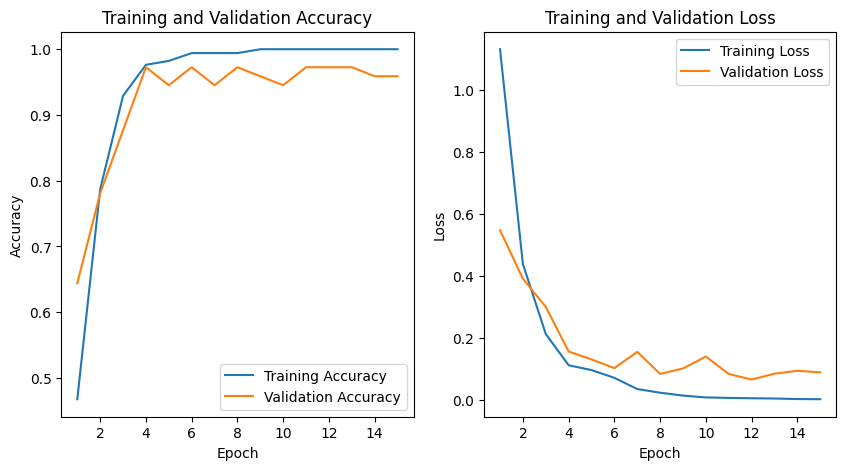

In [17]:
# plotting the results
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].plot(result_df['Epoch'], result_df['Accuracy'], label='Training Accuracy')
ax[0].plot(result_df['Epoch'], result_df['Val_Accuracy'], label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(result_df['Epoch'], result_df['Loss'], label='Training Loss')
ax[1].plot(result_df['Epoch'], result_df['Val_Loss'], label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

3/3 [==============================] - 6s 2s/step


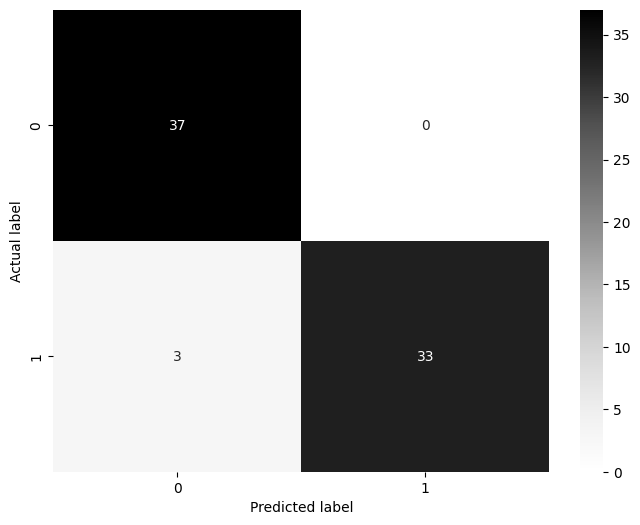

In [18]:
# get the predicted target label (probability)
y_pred_prob = model.predict(X_test)

# converting to the binary
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
# showing precision, recall, f1-score
print(classification_report(y_test, y_pred))

# showing accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        37
           1       1.00      0.92      0.96        36

    accuracy                           0.96        73
   macro avg       0.96      0.96      0.96        73
weighted avg       0.96      0.96      0.96        73

Accuracy: 0.958904109589041


ROC AUC Score: 0.9992492492492493


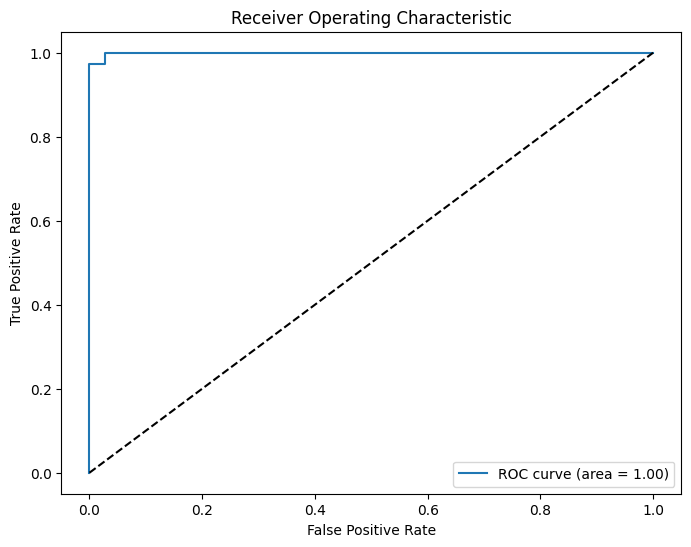

In [20]:
# calculating area under ROC curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# plotting the ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")